<style>
    *{
        font-size: 14px;
    }

    h1{
        font-size: 24px;
        text-align: center;
        font-weight: bold;
    }

    h2{
        font-size: 16px;
        display: inline-block;
        
    }


    span{
        font-style: oblique;
    }
    
    a{
        text-decoration: underline;
    }
</style>


<p><h2>1.</h2> <a href="https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality">https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality</a> - выбранный датасет.</p>

<p><h2>2.</h2></p>

In [2]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('apple_quality.csv')

print(df.head()) 

   A_id      Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
0     0 -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840   
1     1 -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530   
2     2 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033   
3     3 -0.657196 -2.271627   1.324874    -0.097875   3.637970 -3.413761   
4     4  1.364217 -1.296612  -0.384658    -0.553006   3.030874 -1.303849   

    Acidity Quality  
0 -0.491590    good  
1 -0.722809    good  
2  2.621636     bad  
3  0.790723    good  
4  0.501984    good  


Исключим столбец A_id и преобразуем классификацию качества яблок "good"/"bad" в "1"/"0"
Затем разделим данные на тестовые и тренировочные

In [ ]:

df= df.drop(df.columns[0], axis=1)

df['Quality_binary'] = df['Quality'].apply(lambda x: 1 if x == "good" else 0)   

X = df.drop(columns = ['Quality', 'Quality_binary'])
y = df['Quality_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

Посмотрим на сбалансированность классов. Они оказались практически полностью сбалансированным: соотношение 50,1:49,9

In [14]:

df['Quality_binary'].value_counts()

Quality_binary
1    2004
0    1996
Name: count, dtype: int64

Применим метод SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_test = scaler.transform(X_test)

Обучим kNN и дерево решений для дальнейшего сравнения

In [ ]:
knn = KNeighborsClassifier(n_neighbors=2)
dec_tree = DecisionTreeClassifier(random_state=42)

knn.fit(X_train_smote, y_train_smote)
y_pred_knn_smote = knn.predict(X_test)

dec_tree.fit(X_train_smote, y_train_smote)
y_pred_tree_smote = dec_tree.predict(X_test)

In [13]:
print(classification_report(y_test, y_pred_knn_smote))
print(classification_report(y_test, y_pred_tree_smote))

              precision    recall  f1-score   support

           0       0.82      0.94      0.87       399
           1       0.93      0.79      0.85       401

    accuracy                           0.86       800
   macro avg       0.87      0.86      0.86       800
weighted avg       0.87      0.86      0.86       800

              precision    recall  f1-score   support

           0       0.80      0.79      0.80       399
           1       0.80      0.81      0.80       401

    accuracy                           0.80       800
   macro avg       0.80      0.80      0.80       800
weighted avg       0.80      0.80      0.80       800



 Построим ROC-кривую

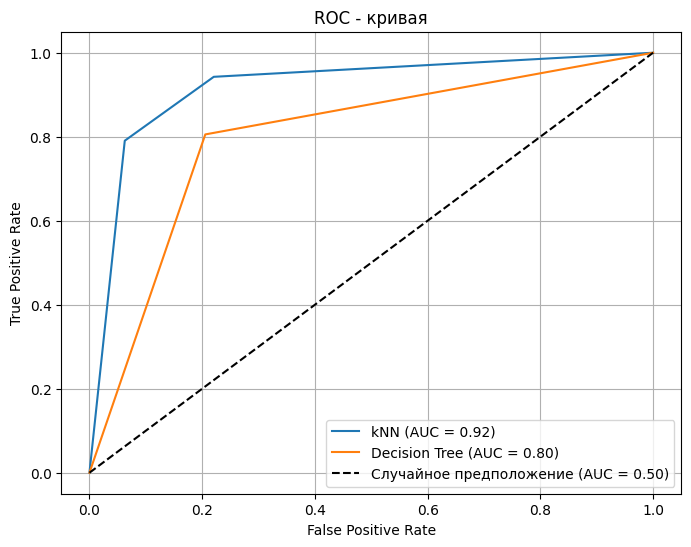

In [15]:
from sklearn.metrics import roc_curve, auc

y_prob_knn = knn.predict_proba(X_test)[:, 1]
y_prob_tree = dec_tree.predict_proba(X_test)[:, 1]

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)

roc_auc_knn = auc(fpr_knn, tpr_knn)
roc_auc_tree = auc(fpr_tree, tpr_tree)

plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label=f"kNN (AUC = {roc_auc_knn:.2f})")
plt.plot(fpr_tree, tpr_tree, label=f"Decision Tree (AUC = {roc_auc_tree:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Случайное предположение (AUC = 0.50)")
plt.title("ROC - кривая")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

<style>
    *{
        font-size: 14px;
    }

    h1{
        font-size: 24px;
        text-align: center;
        font-weight: bold;
    }

    h2{
        font-size: 16px;
        display: inline-block;
        
    }


    span{
        font-style: oblique;
    }
    
    a{
        text-decoration: underline;
    }
</style>

<p><h2>3.</h2></p>

Вывод:

1. Класс "Плохие яблоки" (0):

| Модель        | Precision | Recall | F-score |
|---------------|-----------|--------|---------|
| kNN           | 0,82      | 0,94   | 0,87    |
| Decision Tree | 0,80      | 0,79   | 0,80    |

Исходя из метрик Precision и Recall можно понять, что kNN немного лучше предсказывает и сильно лучше распознает плохие яблоки. Значения F-score указывают на то, что kNN имеет более сбалансированное поведение.

2. Класс "Хорошие яблоки" (1):

| Модель        | Precision | Recall | F-score |
|---------------|-----------|--------|---------|
| kNN           | 0,93      | 0,79   | 0,85    |
| Decision Tree | 0,80      | 0,81   | 0,80    |

Можно заметить, что kNN значительно лучше предсказывает хорошие яблоки, однако дерево решений распознает хорошие яблоки чуть лучше.

3. Общий показатель

Метод kNN показывает более высокую точность, нежели дерево решений - Accuracy: 0,86 против 0,80

4. ROC
Исходя из ROC - кривой, метод kNN имеет большую площадь под графиком, что указывает на лучшее разделение классов, нежели при использовании дерева решений.

Таким образом, kNN лучше подошел для выбранного датасета, обеспечив более высокую точность и общее качество. Однако, если важно минимизировать пропуски класса "хороших яблок" (важен Recall), то Decision Tree показывает слегка лучший результат.